In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import utils.utils as utils
import utils.dataloader_utils as dataloader_utils
import utils.train_utils as train_utils

import json
from tqdm import tqdm

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2022-11-01 08:19:07.842460: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[]

In [3]:
tfp.__version__, tf.__version__

('0.16.0', '2.8.0')

# Load Data

In [4]:
BATCH_SIZE = 1024
num_points_in_one_traj = 81
object_type = 'pedestrain' #

In [5]:
if object_type == 'vehicle':
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_select_non_outlier_indicies.json', "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json')
    combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))
else:
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_outlier_indicies.json', "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json', idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'agt_traj')
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 231508/231508 [03:29<00:00, 1106.52it/s]


tf.Tensor(126, shape=(), dtype=int64)


found
(689, 81) (689, 162) (689, 81) (689, 81) (689, 81, 2, 2)


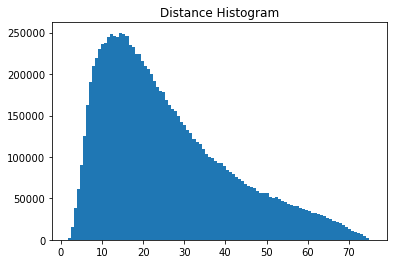

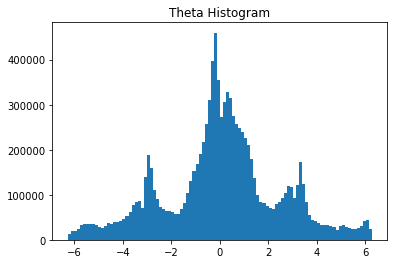

In [17]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

d_all = np.zeros((list_dataset.__len__(), num_points_in_one_traj))
theta_all = np.zeros((list_dataset.__len__(), num_points_in_one_traj))    
    
start_idx = 0

for times, agt_traj, d_norm, theta, R_ego_to_map in dataProcessor.loaded_dataset:
    batch_size = times.shape[0]    
    d_all[start_idx:start_idx+batch_size] = d_norm
    theta_all[start_idx:start_idx+batch_size] = theta
    start_idx = start_idx+batch_size
    
    
    
ax1.hist(d_all.reshape(-1), bins = 100)
ax1.set_title('Distance Histogram')
ax2.hist(theta_all.reshape(-1), bins = 100)
ax2.set_title('Theta Histogram')
print(times.shape, agt_traj.shape, d_norm.shape, theta.shape, R_ego_to_map.shape)

# Training

In [7]:
EPOCHS = 1
lr = 5e-3

In [8]:
losses = []
best_losses = []
best_epoch_losses = []
best_epochs = []
bic_scores = []
aic_scores = []
A_list, B_list = [], []
optimizers_ser = []
t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory, for scaling time to interval (0,1)
log_root_dir = 'logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + 'test'
nan_batches = []
degrees = np.linspace(1, 8, 8, dtype=np.int16) # Analyse polynomials from degree 1 to 8
#degrees = [7]
for i_d, deg in enumerate(degrees):
    print('Trainig deg ',deg)
    model_losses = []
    
    # Initialize optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)   
    optimizers_ser.append(tf.keras.optimizers.serialize(optimizer))
    
    # Initialize all trainable variables
    A = tf.Variable(np.random.randn(2*(deg), 2*(deg))*1e-1, dtype=tf.float64, name='alpha') # Model uncertainty
    B_d = tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_d') 
    B_theta = tf.Variable(np.random.randn(1), dtype=tf.float64, name='beta_theta')
    B_const =  tf.Variable(np.random.randn(1), dtype=tf.float64, name='beta_const')
    
    # Initialize tf summary writer
    train_log_dir = log_root_dir + '/deg_' + str(deg)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
    
    # Start Training
    best_epoch_loss, best_epoch, best_alpha, best_beta_d, best_beta_theta, best_beta_const = train_utils.train_agt(alpha=A, beta_d=B_d, beta_theta=B_theta, beta_const = B_const, t_scale_factor = t_scale_factor, degree = deg,
                                                                                                                   opti=optimizer, epochs = EPOCHS, data_loader=dataProcessor.loaded_dataset, model_losses = model_losses, 
                                                                                                                   tf_summary_writer = train_summary_writer, verbose = True, early_stop=False)
            
    # Add loss
    losses.append(model_losses)
    best_epoch_losses.append([best_epoch_loss])
    
    # store the best epoch
    best_epochs.append(best_epoch)
    
    # Compute AIC and BIC
    aic_score, bic_score = utils.compute_AIC_BIC(nll = best_epoch_loss, deg = deg, num_points = num_points_in_one_traj)

    bic_scores.append(bic_score)
    aic_scores.append(aic_score)
    
    # Compute the model uncertainty, A_unscaled = np.linalg.inv(scale_mat) @ A_scaled
    A_scale_mat = utils.polyBasisScale(t_scale_factor, deg)
    A_scale_mat = A_scale_mat[1:, 1:]
    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ best_alpha.numpy()
    A_est = A_est @ A_est.T # This is the unscaled model parameter covariance
    A_list.append(A_est)
    
    # Compute the observation uncertainty and store
    B_est = {'B_d': (tf.math.softplus(best_beta_d)).numpy(), 'B_theta': (tf.math.softplus(best_beta_theta)).numpy(),'B_const': (tf.math.softplus(best_beta_const)).numpy()}
    B_list.append(B_est)
    print(deg, model_losses[-1], bic_score, aic_score)

Trainig deg  1


100%|██████████| 1/1 [00:40<00:00, 40.57s/it]


Epoch  0 , Loss:  257.8051787966857
1 257.8051787966857 266.3901468078986 262.8051787966857
Trainig deg  2


100%|██████████| 1/1 [00:41<00:00, 41.38s/it]


Epoch  0 , Loss:  240.70338515924982
2 240.70338515924982 261.3073083861607 252.70338515924982
Trainig deg  3


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Epoch  0 , Loss:  233.07597305631188
3 233.07597305631188 272.5668259078911 256.0759730563119
Trainig deg  4


  0%|          | 0/1 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [39]:
result = utils.calculate_result(degrees, bic_scores, aic_scores, A_list, B_list, best_epoch_losses, best_epochs, lr, optimizers_ser, EPOCHS, BATCH_SIZE)

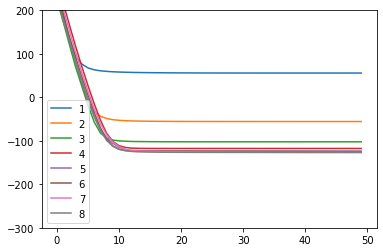

In [40]:
fig,ax = utils.plot_losses(losses, degrees = degrees, y_lim=[-300, 200])
fig.savefig('imgs/agt_polar_' + str(num_points_in_one_traj) + '.svg')

In [41]:
result['best_aic_A']

array([[ 3.94339629e+01,  1.16404827e-02, -9.29584282e-02,
         7.41671924e-03, -1.08149368e+00,  1.61152348e-01,
        -2.71617750e-03, -2.29815780e-03],
       [ 1.16404827e-02,  4.17862715e-01, -8.69220593e-02,
         9.17814406e-03, -1.89623895e-01,  9.42947231e-04,
         6.54669718e-03, -7.63638853e-04],
       [-9.29584282e-02, -8.69220593e-02,  5.44648143e-02,
        -8.02327579e-03, -1.21727809e-03, -5.29639190e-03,
        -5.02553850e-04,  1.64431398e-04],
       [ 7.41671924e-03,  9.17814406e-03, -8.02327579e-03,
         1.36162456e-03,  2.09353081e-03,  5.67036122e-04,
        -2.78058429e-05, -7.16999214e-06],
       [-1.08149368e+00, -1.89623895e-01, -1.21727809e-03,
         2.09353081e-03,  4.36133058e+01, -5.98540043e-02,
        -1.00160283e-01,  9.38994870e-03],
       [ 1.61152348e-01,  9.42947231e-04, -5.29639190e-03,
         5.67036122e-04, -5.98540043e-02,  4.65916147e-01,
        -9.68304337e-02,  1.02888372e-02],
       [-2.71617750e-03,  6.546697

In [42]:
result['best_aic_B']

{'B_d': array([[5.91219464e-05],
        [4.20220285e-06],
        [6.35112276e-07]]),
 'B_theta': array([1.13355014e-07]),
 'B_const': array([0.0001483])}

In [43]:
utils.save_result(folder_dir =log_root_dir, file_name='result_summary', result=result)
with open(log_root_dir + '/' + 'lr_schedules' + '.json', "w") as write_file:
    json.dump(lr_schedules_ser, write_file, cls=NumpyEncoder)
with open(log_root_dir + '/' + 'optimizers' + '.json', "w") as write_file:
    json.dump(optimizers_ser, write_file, cls=NumpyEncoder)

Text(0, 0.5, '[m]')

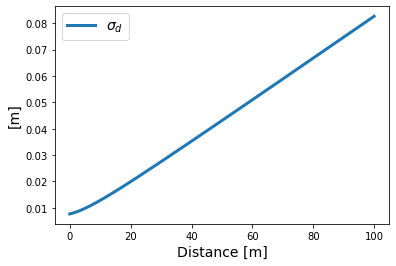

In [45]:
fig, ax = plt.subplots()
d = np.linspace(0, 100, 1000)
theta = 0
sigmas_d = []

#wd = (tf.math.softplus(B_d)).numpy()
wd = (result['best_aic_B']['B_d'])
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_d.append(sigma)
ax.plot(d, sigmas_d, label = '${\sigma}_{d}$', linewidth = 3)  
ax.legend(fontsize=14)
ax.set_xlabel("Distance [m]", fontsize=14)
ax.set_ylabel("[m]", fontsize=14)

Text(0, 0.5, '(m)')

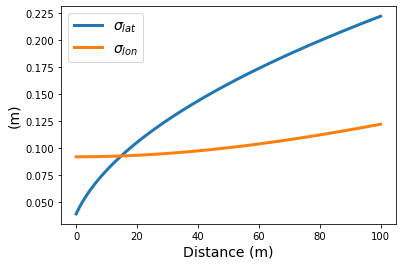

In [152]:
fig, ax = plt.subplots()
d = np.linspace(0, 100, 1000)
sigmas_lat = []
sigmas_lon = []
wd = np.array(result['best_aic_B']['B_lat'])
#wd = tf.math.softplus(best_beta_lat)
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_lat.append(sigma)
ax.plot(d, sigmas_lat, label = '${\sigma}_{lat}$', linewidth = 3)  


wd = np.array(result['best_aic_B']['B_lon'])
#wd = tf.math.softplus(best_beta_lon)
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_lon.append(sigma)
    

ax.plot(d, sigmas_lon, label = '${\sigma}_{lon}$', linewidth = 3) 
ax.legend(fontsize=14)
ax.set_xlabel("Distance (m)", fontsize=14)
ax.set_ylabel("(m)", fontsize=14)

# Dummy Code

In [20]:
num_points_in_one_traj = 91
deg_to_change = 7
idx_to_change = deg_to_change-1
with open('logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '/result_summary.json', "r") as read_file:
    result_old = json.load(read_file)
          
with open('logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '_only_' + str(deg_to_change) + 'th/result_summary.json', "r") as read_file:
    result_sub = json.load(read_file)

In [21]:
result_old['losses'][idx_to_change] = result_sub['losses'][0]
result_old['A_list'][idx_to_change] = result_sub['A_list'][0]
result_old['B_list'][idx_to_change] = result_sub['B_list'][0]

result_old['lr'][idx_to_change] = result_sub['lr'][0]
result_old['optimizer'][idx_to_change] = result_sub['optimizer'][0]

result_old['bic_scores'][idx_to_change] = result_sub['bic_scores'][0]
best_bic_deg_idx = np.where(result_old['bic_scores'] == np.amin(result_old['bic_scores']))[0][0]
result_old['best_bic'] = result_old['bic_scores'][best_bic_deg_idx]
result_old['best_bic_A'] = result_old['A_list'][best_bic_deg_idx]
result_old['best_bic_B'] = result_old['B_list'][best_bic_deg_idx]
result_old['best_bic_deg'] = result_old['degree'][best_bic_deg_idx]
result_old['best_bic_deg_idx'] = best_bic_deg_idx


result_old['aic_scores'][idx_to_change] = result_sub['aic_scores'][0]
best_aic_deg_idx = np.where(result_old['aic_scores'] == np.amin(result_old['aic_scores']))[0][0]
result_old['best_aic'] = result_old['aic_scores'][best_aic_deg_idx]
result_old['best_aic_A'] = result_old['A_list'][best_aic_deg_idx]
result_old['best_aic_B'] = result_old['B_list'][best_aic_deg_idx]
result_old['best_aic_deg'] = result_old['degree'][best_aic_deg_idx]
result_old['best_aic_deg_idx'] = best_aic_deg_idx

with open('logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '/result_summary_new.json', "w") as write_file:
    json.dump(result_old, write_file, cls=NumpyEncoder)